In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_heat.nc').budg_heat

In [3]:
budgFw = budgFw.sel(time=slice('1993-01-01','2015-12-31'))
budgH = budgH.sel(time=slice('1993-01-01','2015-12-31'))

In [4]:
dif_ConvFw = budgFw.sel(term='tendFw')[:,:-1] - budgFw.sel(term='totalFw')[:,:-1]

In [5]:
budgH_anom = budgH.groupby('time.month') - budgH.groupby('time.month').mean('time')
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')
dif_ConvFw_anom = dif_ConvFw.groupby('time.month') - dif_ConvFw.groupby('time.month').mean('time')

In [6]:
budgH_anom = budgH_anom[:,:,:-1]
budgFw_anom = budgFw_anom[:,:,:-1]
dif_ConvFw_anom = dif_ConvFw_anom[:,:-1]

### Plot

In [7]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

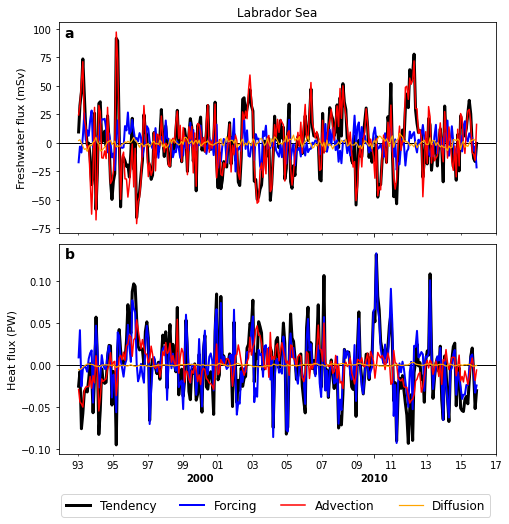

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='tendFw')*1e3, 
              lw=3, color='black',label='Tendency')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='forcFw')*1e3, 
              lw=2, color='blue',label='Forcing')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_ConvFw')*1e3, 
              lw=1.5, color='red',label='Advection')
axs[0].plot(dif_ConvFw_anom.time, dif_ConvFw_anom.sel(region='lsea')*1e3, lw=1.2, color='orange',label='Diffusion')
axs[0].set_ylabel(r'Freshwater flux (mSv)',fontsize=11)
axs[0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0].transAxes)
axs[0].set_title(r'Labrador Sea', fontsize=12)

axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='tendH')*1e-15, 
              lw=3, color='black',label='Tendency')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='forcH')*1e-15, 
              lw=2, color='blue',label='Forcing')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='adv_ConvH')*1e-15, 
              lw=1.5, color='red',label='Advection')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='dif_ConvH')*1e-15, 
              lw=1.2, color='orange',label='Diffusion')
axs[1].set_ylabel(r'Heat flux (PW)', fontsize=11)
axs[1].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].legend(frameon=True, fancybox=True, bbox_to_anchor=(1.0, -0.16), ncol=4, fontsize=12)

format_xaxis(axs[1])
fig.subplots_adjust(left=0.17, right=0.93, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

### Covariance ratio

In [11]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

In [35]:
def convert_to_df(arr,region,terms):
    
    # Load time series to dataframe
    df = arr.sel(region=region, term=terms).reset_coords(drop=True).to_dataframe()
    
    # Unstack
    df = df.unstack(level='term').reset_index()
    
    # Convert MultiIndex to Index
    df.columns = df.columns.map(''.join)
    
    # Set time as index
    df.set_index('time',inplace=True)
    
    # Rename columns
    #df.rename(columns = lambda x : str(x)[7:],inplace=True)
    df.rename(columns = lambda x : str(x)[9:],inplace=True)

    return df

In [36]:
#df = convert_to_df(budgFw_anom,'lsea',['tendFw','forcFw','ConvFw','totalFw'])
#df['res'] = df.tendFw - df.totalFw

df = convert_to_df(budgH_anom,'lsea',['tendH','forcH','adv_ConvH','dif_ConvH'])

df['dt'] = ecco.reset_coords().dt.sel(time=slice('1993-01-01','2015-12-31')).to_dataframe().dt

In [37]:
df

,adv_ConvH,dif_ConvH,forcH,tendH,dt
time,,,,,
1993-01-15,-2.903662e+13,-5.258717e+12,9.191045e+12,-2.510430e+13,2678400.0
1993-02-12,-4.399572e+13,-5.404366e+12,4.171635e+13,-7.683694e+12,2419200.0
1993-03-15,-4.613314e+13,-4.261988e+12,-2.548763e+13,-7.588277e+13,2678400.0
1993-04-14,-5.003231e+13,-2.611361e+12,-4.985646e+12,-5.762931e+13,2592000.0
1993-05-15,-2.976250e+13,-1.171477e+12,-8.926830e+11,-3.182666e+13,2678400.0
...,...,...,...,...,...
2015-07-15,6.451382e+10,3.496503e+11,1.009793e+13,1.051210e+13,2678400.0
2015-08-15,8.555188e+12,-8.932875e+11,1.276719e+13,2.042909e+13,2678400.0
2015-09-14,-1.982023e+12,-1.329800e+12,-6.049628e+12,-9.361440e+12,2592000.0


In [38]:
# Annual
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

In [39]:
# Pentad
df_sub = df.loc[(df.index > '1994-12-31')&(df.index < '2015-01-01')]
df_5yr = df_sub.multiply(df_sub["dt"], axis="index").resample('5A',kind='period').mean().drop(columns=['dt'])

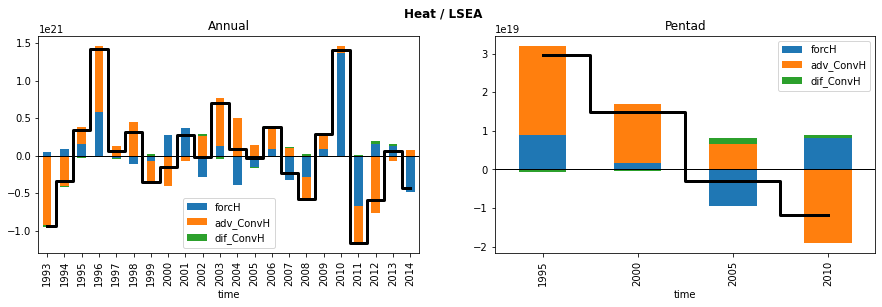

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

#df_1yr[['forcFw','ConvFw','res']].plot.bar(stacked=True,ax=axs[0])
df_1yr[['forcH','adv_ConvH','dif_ConvH']].plot.bar(stacked=True,ax=axs[0])
#axs[0].step(df_1yr.index.strftime('%Y'), df_1yr.tendFw, where='mid', c='k', lw=3, linestyle='-')
axs[0].step(df_1yr.index.strftime('%Y'), df_1yr.tendH, where='mid', c='k', lw=3, linestyle='-')
axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].set_title('Annual')

#df_5yr[['forcFw','ConvFw','res']].plot.bar(stacked=True,ax=axs[1])
df_5yr[['forcH','adv_ConvH','dif_ConvH']].plot.bar(stacked=True,ax=axs[1])
#axs[1].step(df_5yr.index.strftime('%Y'), df_5yr.tendFw, where='mid', c='k', lw=3, linestyle='-')
axs[1].step(df_5yr.index.strftime('%Y'), df_5yr.tendH, where='mid', c='k', lw=3, linestyle='-')
axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].set_title('Pentad')

#fig.suptitle('Freshwater / LSEA',fontweight='bold')
fig.suptitle('Heat / LSEA',fontweight='bold')

plt.show()

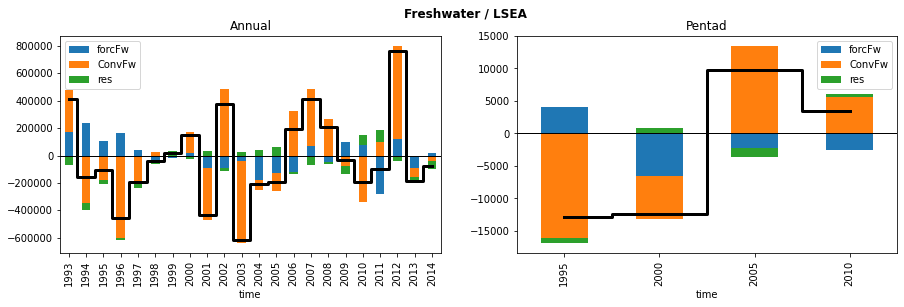

In [41]:
def cov_ratio(df,y):
    return pd.Series({term: df[y].cov(df[term]) for term in df if term != y})/np.var(df[y],ddof=1)

### Freshwater

In [30]:
corr1mo = cov_ratio(df.drop(columns=['dt']),'tendFw').to_frame(name='monthly')
corr1yr = cov_ratio(df_1yr,'tendFw').to_frame(name='annual')
corr5yr = cov_ratio(df_5yr,'tendFw').to_frame(name='pentad')

print('Freshwater')
dfFw = corr1mo.join(corr1yr.join(corr5yr))
print(dfFw)

Freshwater / SPNA
          monthly    annual    pentad
ConvFw   0.934767  0.999181  1.099259
forcFw   0.085762  0.067572 -0.060394
totalFw  1.020529  1.066753  1.038864
res     -0.020529 -0.066753 -0.038864


In [31]:
dfFw.drop(index='totalFw',inplace=True)
dfFw.rename(index={'ConvFw': 'Advection','res': 'Diffusion','forcFw': 'Forcing'},inplace=True)
dfFw = dfFw.reindex(['Forcing', 'Advection', 'Diffusion'])
dfFw.columns=pd.MultiIndex.from_tuples([('Freshwater','monthly'),('Freshwater','annual'),('Freshwater','pentad')])

In [32]:
dfFw

Freshwater                    
             monthly    annual    pentad
Forcing     0.085762  0.067572 -0.060394
Advection   0.934767  0.999181  1.099259
Diffusion  -0.020529 -0.066753 -0.038864

In [20]:
dfFw_nsea.drop(index='totalFw',inplace=True)
dfFw_nsea.rename(index={'ConvFw': 'Advection','res': 'Diffusion','forcFw': 'Forcing'},inplace=True)
dfFw_nsea = dfFw_nsea.reindex(['Forcing', 'Advection', 'Diffusion'])
dfFw_nsea.columns=pd.MultiIndex.from_tuples([('NSEA','monthly'),('NSEA','annual'),('NSEA','pentad')])

In [21]:
dfFw_nsea

NSEA                    
            monthly    annual    pentad
Forcing    0.578527  0.580365  1.077277
Advection  0.436282  0.455811  0.227294
Diffusion -0.014809 -0.036177 -0.304570

In [23]:
dfFw = dfFw_spna.join(dfFw_nsea)
dfFw.columns=pd.MultiIndex.from_tuples([('Freshwater','SPNA','monthly'),('Freshwater','SPNA','annual'),
                                        ('Freshwater','SPNA','pentad'),('Freshwater','NSEA','monthly'),
                                        ('Freshwater','NSEA','annual'),('Freshwater','NSEA','pentad')])

In [28]:
dfFw

Freshwater                                                  
                SPNA                          NSEA                    
             monthly    annual    pentad   monthly    annual    pentad
Forcing     0.157787  0.244330 -0.048130  0.578527  0.580365  1.077277
Advection   0.880479  0.870442  1.255324  0.436282  0.455811  0.227294
Diffusion  -0.038266 -0.114773 -0.207194 -0.014809 -0.036177 -0.304570

### Heat

In [42]:
corr1mo = cov_ratio(df.drop(columns=['dt']),'tendH').to_frame(name='monthly')
corr1yr = cov_ratio(df_1yr,'tendH').to_frame(name='annual')
corr5yr = cov_ratio(df_5yr,'tendH').to_frame(name='pentad')

print('Heat')
dfH = corr1mo.join(corr1yr.join(corr5yr))
print(dfH)

Heat
            monthly    annual    pentad
adv_ConvH  0.288823  0.534175  0.901341
dif_ConvH -0.003927 -0.011986 -0.045514
forcH      0.713411  0.477811  0.144173


In [43]:
dfH.rename(index={'adv_ConvH': 'Advection','dif_ConvH': 'Diffusion','forcH': 'Forcing'},inplace=True)
dfH = dfH.reindex(['Forcing', 'Advection', 'Diffusion'])
dfH.columns = pd.MultiIndex.from_tuples([('Heat','monthly'),('Heat','annual'),('Heat','pentad')])

In [44]:
dfH

Heat                    
            monthly    annual    pentad
Forcing    0.713411  0.477811  0.144173
Advection  0.288823  0.534175  0.901341
Diffusion -0.003927 -0.011986 -0.045514

In [42]:
dfH = dfH_spna.join(dfH_nsea)
dfH.columns=pd.MultiIndex.from_tuples([('Heat','SPNA','monthly'),('Heat','SPNA','annual'),
                                       ('Heat','SPNA','pentad'),('Heat','NSEA','monthly'),
                                       ('Heat','NSEA','annual'),('Heat','NSEA','pentad')])

In [45]:
df = dfFw.join(dfH)

In [46]:
df

Freshwater                          Heat                    
             monthly    annual    pentad   monthly    annual    pentad
Forcing     0.085762  0.067572 -0.060394  0.713411  0.477811  0.144173
Advection   0.934767  0.999181  1.099259  0.288823  0.534175  0.901341
Diffusion  -0.020529 -0.066753 -0.038864 -0.003927 -0.011986 -0.045514

In [47]:
from openpyxl import Workbook

In [48]:
df.to_excel('/mnt/efs/table.xlsx')